# Rossmann Store Sales
 <a href="https://www.kaggle.com/c/rossmann-store-sales" target="_blank">Source: Kaggle</a>

## Business Problem

### Scenario

Rossmann operates over 3,000 drug stores in 7 European countries. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

### Task

Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance.

# Enviroment

## Installations

In [ ]:
!pip install -r requirements.txt

In [21]:
#!pip install pandas
#!pip install inflection
#!pip install seaborn
#!pip install plotly
#!pip install tabulate
#!pip install boruta
#!pip install XGBoost
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn

ERROR: Could not find a version that satisfies the requirement peakle (from versions: none)
ERROR: No matching distribution found for peakle


## Imports

In [1]:
# Data extraction
import pandas     as pd
import inflection

# Transformation
import math
import numpy    as np
from   datetime import datetime
from   datetime import timedelta

# Exploratory Data Analysis
import seaborn             as sns
from   tabulate            import tabulate
import matplotlib
from   scipy.stats         import chi2_contingency
import plotly.express      as px
from   IPython.display     import Image
import matplotlib.pyplot   as plt
from   matplotlib.gridspec import GridSpec

# Modeling
from boruta                import BorutaPy
import xgboost             as xgb
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
import random
import pickle

## Settings

In [17]:
# Suprimir notação científica no Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
matplotlib.rcParams['figure.figsize'] = (16, 8)
sns.set_style("darkgrid")

## Fuctions

### Exploratory Data Analysis

In [4]:
def graph_info(title=str):
    '''
    --> Add information about the graph
    '''
    plt.title(title, loc='left', fontsize=18, pad=15.5);

In [5]:
def cramer_v(x, y):
    '''
    --> Categorical variable correlation calc
    
    :param x: column 1
    :param y: column 2
    
    return cramer v correlation
    '''
    #cm: crosstab matrix apply to categoricals variables  
    #n: sum of crosstab matrix 
    #r: rows
    #k: columns
    cm = np.array(pd.crosstab(x, y))
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2_corr / n) / (min(kcorr - 1, rcorr - 1)))

### Machine Learning

In [2]:
def ml_error(model_name=None, y=None, yhat=None):
    '''
    --> Measure the performance of a model 
    
    :param model_name: The name of ML model
    :param y: The real values to validate model performance
    :param yhat: The values predicted by the model to validade
    
    return: DataFrame with the name of a model and mae, mape and mrse measures
    '''
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    mrse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'MRSE': mrse
    }, index=[0])

In [3]:
def cross_validation(x_training, model, model_name, kfold, verbose=False):
    mae_list = list()
    mape_list = list()
    mrse_list = list()
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nK number: {k}')
        validation_start_date = x_training['date'].max() - timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - timedelta(days=(k - 1) * 6 * 7)

        # Training
        # All data that have smaller date than validation_start_date
        training = x_training[x_training['date'] < validation_start_date]

        # Validation
        # All data that have grather or iqual than validation_start_date
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training and validation dataset
        # Training
        xtraining = training.drop(['sales', 'date'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['sales', 'date'], axis=1) 
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_error = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_error['MAE'])
        mape_list.append(m_error['MAPE'])
        mrse_list.append(m_error['MRSE'])
        
    results = pd.DataFrame({
                            'Model': model_name,
                            'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                            'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                            'MRSE CV': np.round(np.mean(mrse_list), 2).astype(str) + ' +- ' + np.round(np.std(mrse_list), 2).astype(str),
                        }, index=[0])
        
    return results

# Data Extraction

## Data Load

In [ ]:
df_sales_raw = pd.read_csv('../dados/rossmann-store-sales/train.csv')
df_store_raw = pd.read_csv('../dados/rossmann-store-sales/store.csv')

/home/mg/Documents/data_science_em_producao/dsproducao/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#df_sales_raw.head(3)

In [ ]:
#df_store_raw.head(3)

In [ ]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='inner', on='Store')

In [ ]:
#df_raw.sample()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
725282    796          4  2013-09-19   5447        646     1      0   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
725282            0              0         a          c              7180.00   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
725282                      11.00                   2012.00       0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval  
725282              NaN              NaN           NaN

## Process File

In [ ]:
#df_raw.to_csv('../dados/procedimentos/df_raw.csv', index=False)

# Transformations

In [ ]:
df1 = pd.read_csv('../data/processing/df_raw.csv')

## Rename Columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
                     'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
                     'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                     'Promo2SinceYear', 'PromoInterval']
# Renomeando as colunas para o padrão snacke case
snackecase = lambda x: inflection.underscore(x)
cols_new = list(map(snackecase, cols_old))
df1.columns = cols_new

## Dimensions

In [ ]:
#print(f'Number of rows: {df1.shape[0]}')
#print(f'Number of columns: {df1.shape[1]}')

## Types

In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
#df1.dtypes

## Missing

In [ ]:
#df1.isna().sum()

## Fill NaN

### competition_distance              

Representa a distância do concorrente mais próximo

Suposição: 
1. Não possuem concorrentes próximos; 
2. A distância com relação ao concorrente é muito longa.

Tratamento: 
1. Preencher as linhas com um registro maior do que a distância máxima registrada na coluna.

In [ ]:
#print(f"Maior distância do concorrente para a loja: {df1['competition_distance'].max()}")
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#print(f"Dados NaN restantes: {df1['competition_distance'].isna().sum()}")                 

### competition_open_since_month

Representa aproximadamente o mês que o concorrente mais próximo abriu a loja

Suposição: 
1. Falta do concorrente próximo;
2. O concorrente próximo abriu a loja antes;
3. A data de abertura do concorrente não foi registrada. 

Tratamento:
1. Extrair da coluna date o mês da data da venda, por considerar que as vendas são influenciadas pela data no qual o concorrente próximo abriu. 

In [ ]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [ ]:
#print(f'Dados faltantes na coluna: {df1["competition_open_since_month"].isna().sum()}')

### competition_open_since_year

Representa aproximadamente o ano que o concorrente mais próximo abriu a loja

Suposição: 
1. Falta do concorrente próximo;
2. O concorrente próximo abriu a loja antes;
3. A data de abertura do concorrente não foi registrada. 

Tratamento:
1. Extrair da coluna date o ano da data da venda, por considerar que as vendas são influenciadas pela data no qual o concorrente próximo abriu. 

In [ ]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [ ]:
#print(f'Dados faltantes na coluna: {df1["competition_open_since_year"].isna().sum()}')

### promo2_since_week

In [ ]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [ ]:
#print(f'Dados faltantes na coluna: {df1["promo2_since_week"].isna().sum()}')

### promo2_since_year 

In [ ]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [ ]:
#print(f'Dados faltantes na coluna: {df1["promo2_since_year"].isna().sum()}')

### promo_interval

In [ ]:
month_map = {1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May',
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sep',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [ ]:
#print(f'Dados faltantes na coluna: {df1["promo_interval"].isna().sum()}')

## Change Data Types

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
#df1.dtypes

## Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attribues

In [ ]:
# Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean))
ct2 = pd.DataFrame(num_attributes.apply(np.median))

# Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame((num_attributes).apply(np.std))
d2 = pd.DataFrame(num_attributes).apply(min)
d3 = pd.DataFrame(num_attributes).apply(max)
d4 = pd.DataFrame(num_attributes).apply(lambda x: x.max() - x.min())
d5 = pd.DataFrame(num_attributes).apply(lambda x: x.skew())
d6 = pd.DataFrame(num_attributes).apply(lambda x: x.kurtosis())

# Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6], axis=1).reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m

### Categorical Attributes

In [ ]:
#cat_attributes.apply(lambda x: x.unique().shape)

In [ ]:
'''
ax1 = df1[df1['sales'] > 0]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=ax1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=ax1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=ax1)
'''

"\nax1 = df1[df1['sales'] > 0]\nplt.subplot(1, 3, 1)\nsns.boxplot(x='state_holiday', y='sales', data=ax1)\n\nplt.subplot(1, 3, 2)\nsns.boxplot(x='store_type', y='sales', data=ax1)\n\nplt.subplot(1, 3, 3)\nsns.boxplot(x='assortment', y='sales', data=ax1)\n"

## Feature Engineering

### Mind Map Hypothesis

Mind Map Hypothesis

Phenomenon
- Sales forecast

Agents:
- Customers, stores, time and products

Agents attributes
- Image below

Hypothesis:
- Topics below

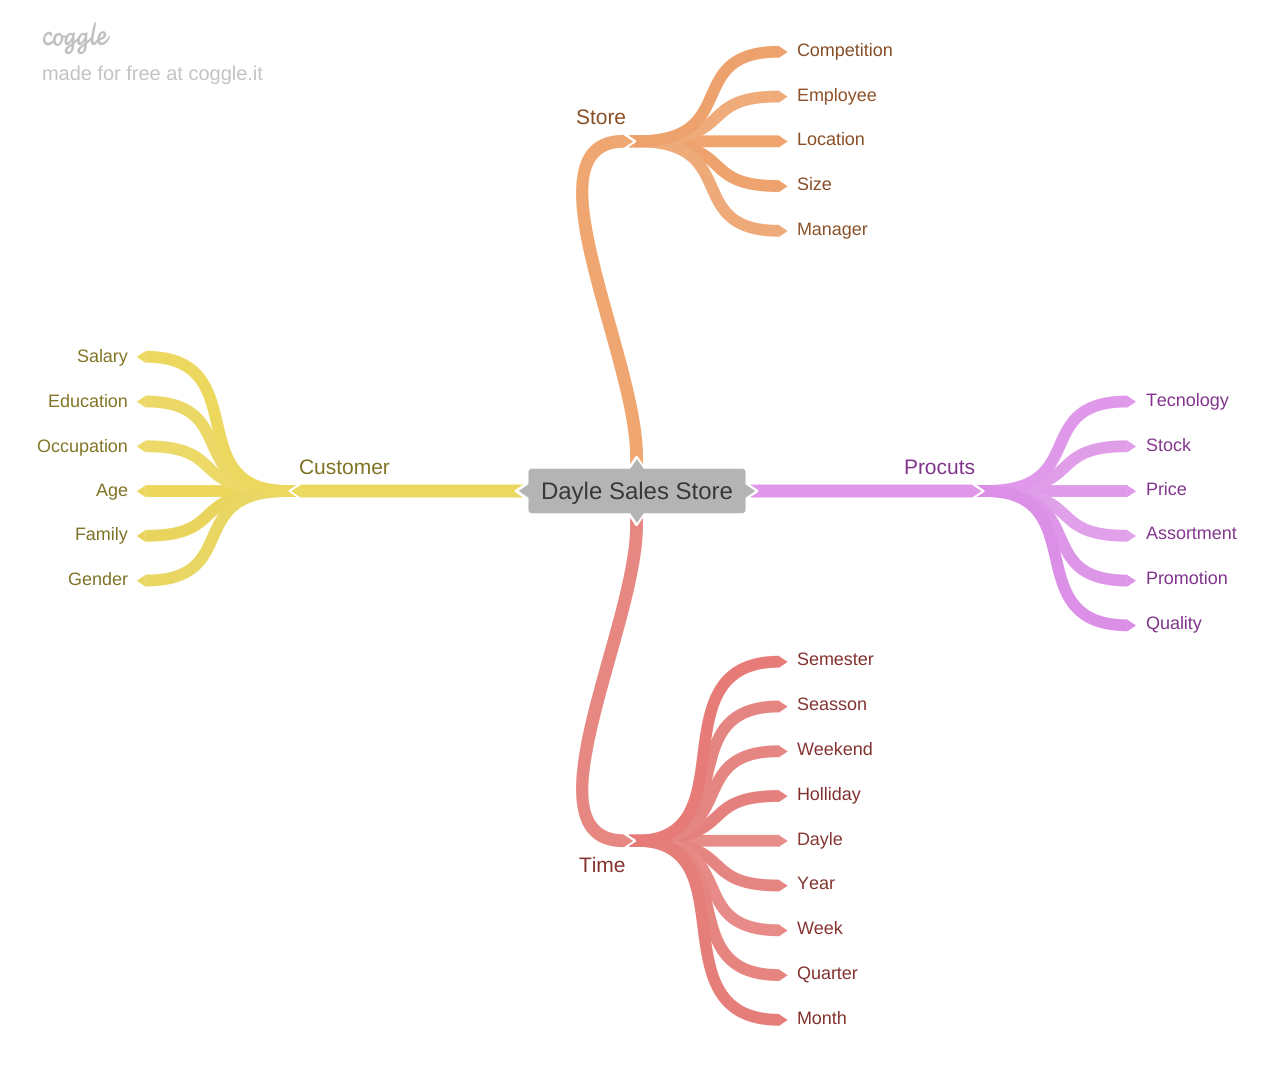

In [ ]:
Image('../img/Dayle_Sales_Store.png')

#### Store Hyphotesis

1. Lojas maiores deveriam vender mais;

2. Lojas com mais funcionários deveriam vender mais;

3. Lojas com concorrentes por perto deveriam vender menos;

4. Lojas com maior estoque deveriam vender mais;

5. Lojas com mais produtos na vitrine deveriam vender mais;

6. Lojas com maior sortimento deveriam vender mais; 

7. Lojas com concorrentes a mais tempo deveriam vender mais;

8. Lojas com promoção ativas deveriam vender mais;

9. Lojas com promoção ativas por mais tempo deveriam vender mais;

10. Lojas com promoção consecutivas deveriam vender mais; 

#### Product Hyphotesis

1. Produtos mais baratos deveriam vender mais;

2. Produtos em promoção deveriam vender mais;

3. Produtos mais caros deveriam vender menos;

4. Produtos com maior qualidade deveriam vender mais;

#### Time Hyphotesis

1. No segundo semestre deveriam aumentar as vendas;

2. No verão as vendas deveriam ser maiores;

3. No final de semana as vendas são menores;

4. Durante as férias escolares as vendas são menores;

5. No natal as vendas são maiores; 

6. As vendas são maiores com o passar dos anos;

### Hyphotesis List

1. Lojas com maior sortimento deveriam vender mais; 

2. Lojas com concorrentes por perto deveriam vender menos;

3. Lojas com concorrentes a mais tempo deveriam vender mais;

4. Lojas com promoção ativas deveriam vender mais;

5. Lojas com promoção ativas por mais tempo deveriam vender mais;

6. Lojas com promoção consecutivas deveriam vender mais; 

7. No natal as vendas são maiores; 

8. As vendas são maiores com o passar dos anos;

9. No segundo semestre deveriam aumentar as vendas;

10. No final de semana as vendas são menores;

11. Durante as férias escolares as vendas são menores;

12. Depois do dia 10 de cada mais as vendas deveriam ser maiores;

### Feature Engineering

In [ ]:
# year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

# day
df1['day'] = df1['date'].dt.day

# week of year
df1['week_of_year'] = df1['date'].dt.isocalendar().week

# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since
df1['competition_since'] = df1.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df1['competition_time_month'] = ((df1['date'] - df1['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df1['promo_time_week'] = ((df1['date'] - df1['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# Assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

# state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## Data Filter

### Row Filter

In [ ]:
df1 = df1[(df1['open'] != 0) & (df1['sales'] > 0)]

### Columns Filter

In [ ]:
df1.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1, inplace=True)

## Process File

In [ ]:
#df1.to_csv('../data/processing/transformations.csv', index=False)

# Exploratory Data Analysis

In [ ]:
df2 = pd.read_csv('../data/processing/df1.csv')

## Univariate Analysis

### Response Variable

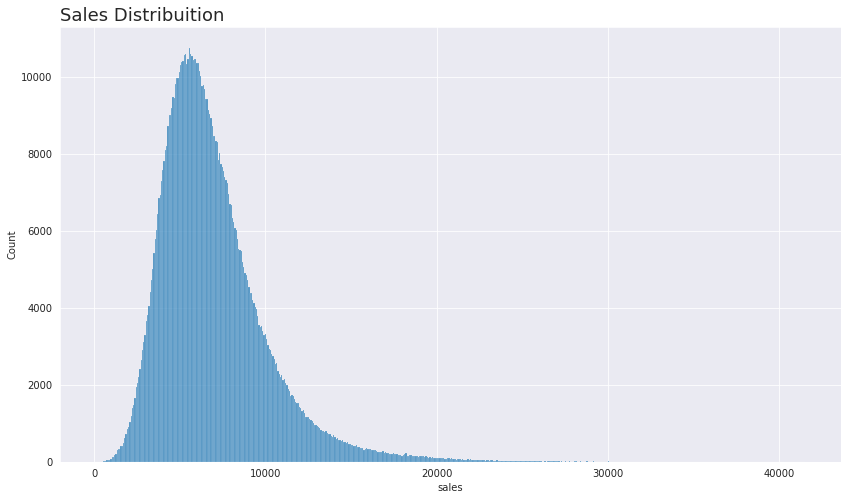

In [ ]:
sns.histplot(df2['sales'])
plt.title('Sales Distribuition', loc='left', fontsize=18);

### Numerical Variable

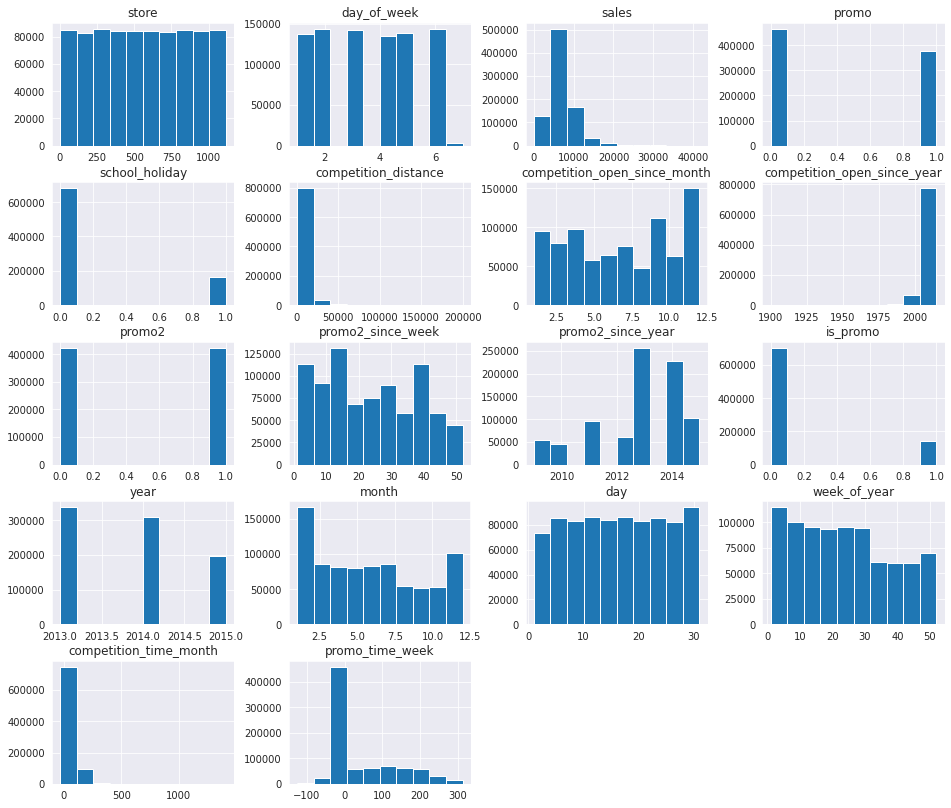

In [ ]:
df2.select_dtypes(include=['int64', 'float64']).hist(figsize=(16, 14));

store: Number of sales by store is closely distribuited

day_of_week: Is balanced in all days

sales: Distribuition is left asymmetric

promo: Have more no promo events

promo2: Have much more no promo2 events

competition_distance: Usually short distances

### Categorical Variable

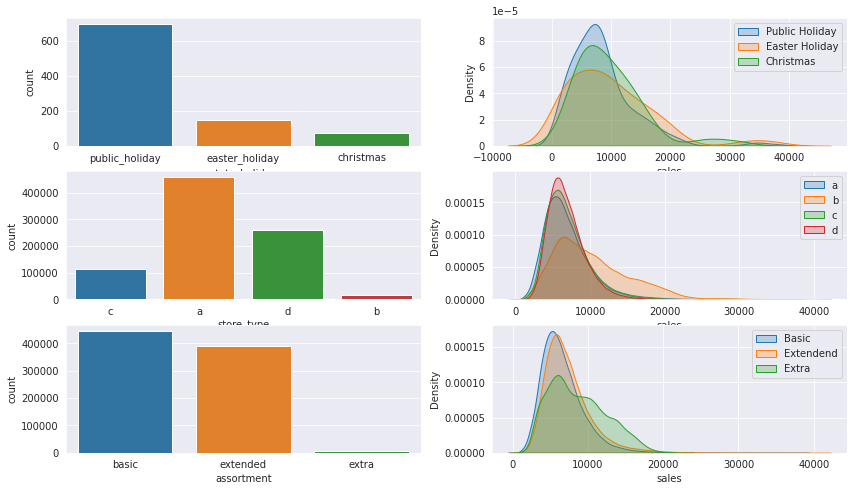

In [ ]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=df2[df2 != 'regular_day'])

plt.subplot(3, 2, 2)
sns.kdeplot(data=df2[df2['state_holiday'] == 'public_holiday']['sales'], shade=True, label='Public Holiday')
sns.kdeplot(data=df2[df2['state_holiday'] == 'easter_holiday']['sales'], shade=True, label='Easter Holiday')
sns.kdeplot(data=df2[df2['state_holiday'] == 'christmas']['sales'], shade=True, label='Christmas')
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df2)

plt.subplot(3, 2, 4)
sns.kdeplot(data=df2[df2['store_type'] == 'a']['sales'], shade=True, label='a')
sns.kdeplot(data=df2[df2['store_type'] == 'b']['sales'], shade=True, label='b')
sns.kdeplot(data=df2[df2['store_type'] == 'c']['sales'], shade=True, label='c')
sns.kdeplot(data=df2[df2['store_type'] == 'd']['sales'], shade=True, label='d')
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df2)

plt.subplot(3, 2, 6)
sns.kdeplot(data=df2[df2['assortment'] == 'basic']['sales'], shade=True, label='Basic')
sns.kdeplot(data=df2[df2['assortment'] == 'extended']['sales'], shade=True, label='Extendend')
sns.kdeplot(data=df2[df2['assortment'] == 'extra']['sales'], shade=True, label='Extra')
plt.legend();

## Bivariate Analysis

### H1 - Stores with more assortment should sell more
*False*

Basic assortment have more sales

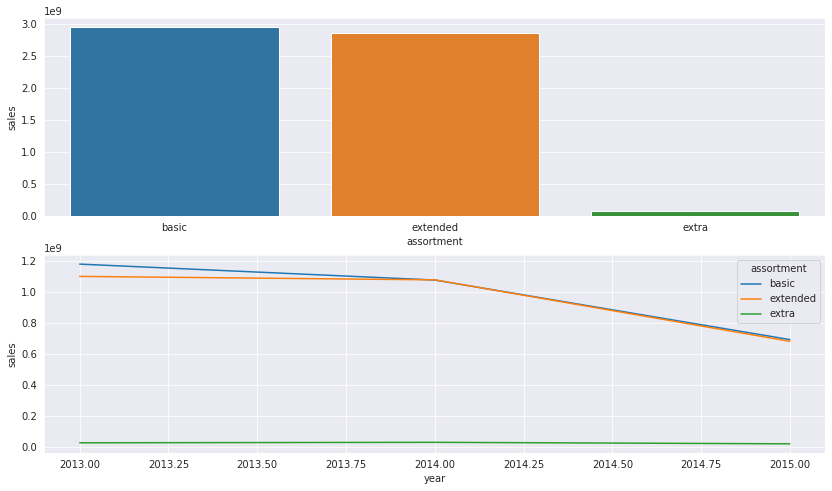

In [ ]:
plt.subplot(2, 1, 1)
aux1 = df2[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df2[['assortment', 'year', 'sales']].groupby(['assortment', 'year']).sum().reset_index()
sns.lineplot(x='year', y='sales', hue='assortment', data=aux2);

In [ ]:
aux3 = df2[df2['assortment'] == 'extra'][['year_week', 'sales']].groupby('year_week').sum().reset_index()
px.line(x=aux3['year_week'], y=aux3['sales'], title='Assortment Extra')

In [ ]:
df2['assortment'].value_counts(normalize=True) * 100

basic      52.69
extended   46.34
extra       0.97
Name: assortment, dtype: float64

The number of stores with assortment equal to extra is much smaller than two others

### H2 - Stores with competition nearby sell less

*False*

Stores with a close competitor sell more.

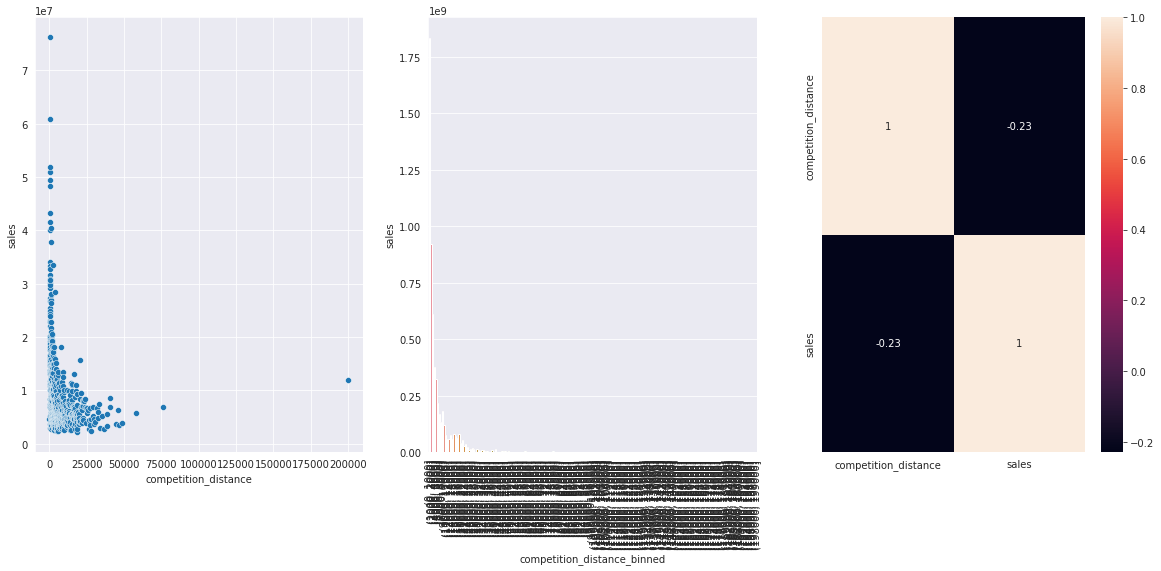

In [ ]:
aux1 = df2[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

bins = np.arange(0, 200000, 1000)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H3 - Stores with longer-term competitors should sell more

*False*

Stores with longer-term competitors sell less

Explanation: When the market is attractive, the opening period for competitors is shorter, as there is great demand for the product.

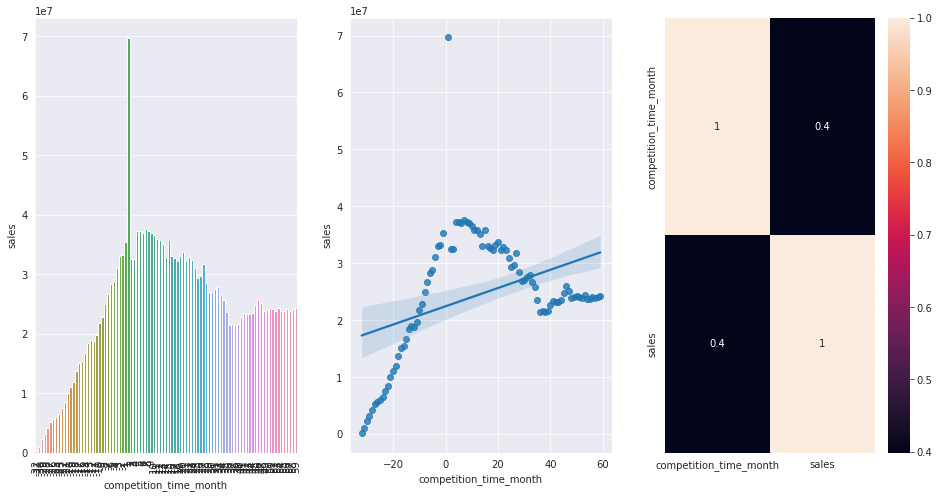

In [ ]:
aux1 = df2[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux1 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4 - Stores with promotions active for longer should sell more

*False*

Longer promotions don't increase sales over time

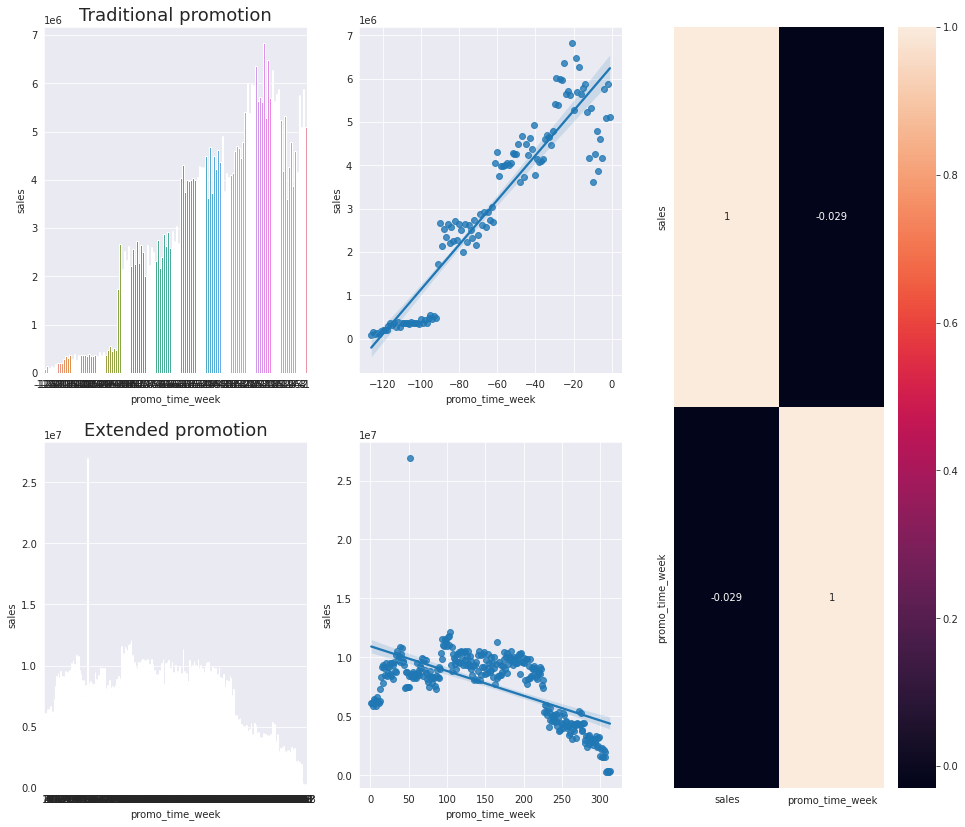

In [ ]:
aux1 = df2[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] < 0] # Traditional
aux3 = aux1[aux1['promo_time_week'] > 0] # Extended

grid = GridSpec(2, 3)

plt.figure(figsize=(16, 14))
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Traditional promotion', fontsize=18)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Extended promotion', fontsize=18)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1[['sales', 'promo_time_week']].corr(), annot=True);

### <s>H5 - Stores with more promotion days should sell more</s>

### H6 - Stores with consecutive promotion should sell more

*False*

Stores with consecutive promotion don't sell more

In [ ]:
df2[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

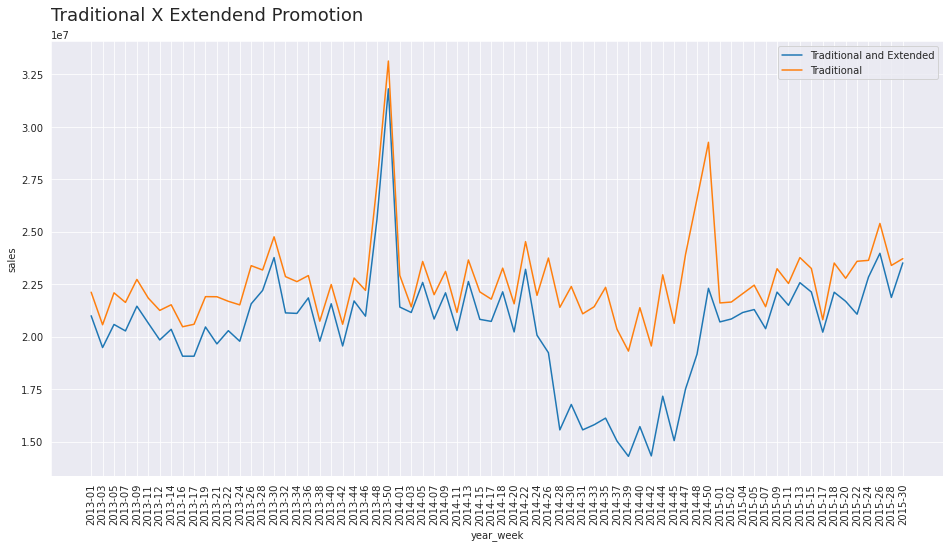

In [ ]:
# traditional and extended
aux1 = df2[(df2['promo'] == 1) & (df2['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

sns.lineplot(x='year_week', y='sales', data=aux1, label='Traditional and Extended')
plt.title('Traditional X Extendend Promotion', loc='left', fontsize=18, pad=20.8)
plt.xticks(rotation=90);

# traditional
aux2 = df2[(df2['promo'] == 1) & (df2['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
sns.lineplot(x='year_week', y='sales', data=aux2, label='Traditional')
plt.title('Traditional X Extendend Promotion', loc='left', fontsize=18, pad=20.8)
plt.xticks(rotation=90)
plt.legend();

To validate in next cicle: Traditional and extended promotions should not have different periods

### H7 - At Christmas sales are higher

*False*

In public holiday sales are higher than christmas

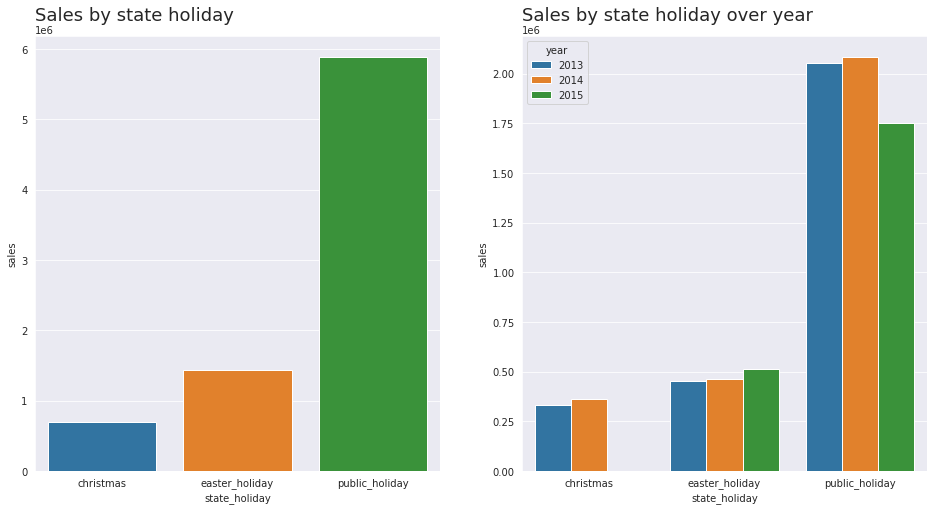

In [ ]:
aux = df2[df2['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title('Sales by state holiday', loc='left', fontsize=18, pad=15.5);

plt.subplot(1, 2, 2)
aux2 = aux[['state_holiday', 'sales', 'year']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', hue='year', data=aux2)
plt.title('Sales by state holiday over year', loc='left', fontsize=18, pad=15.5);

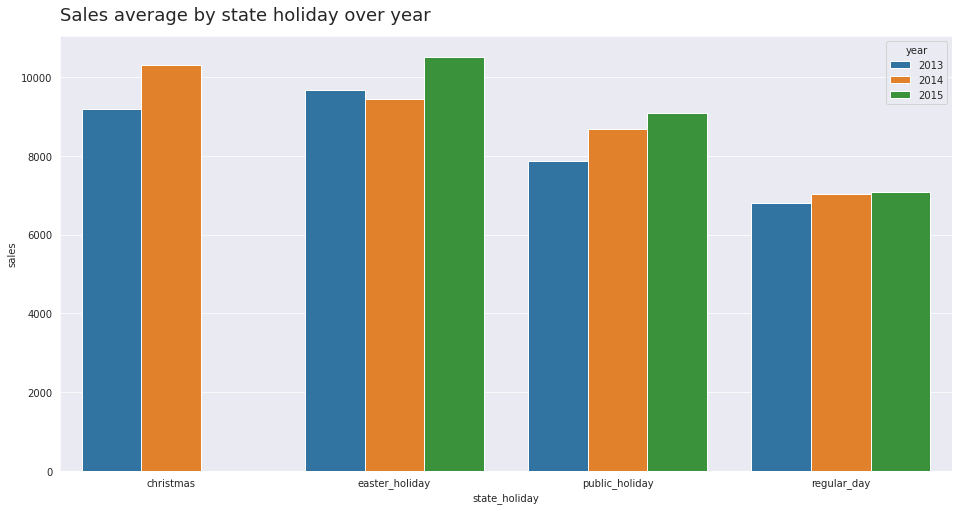

In [ ]:
aux3 = df2[['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).mean().reset_index()

sns.barplot(x='state_holiday', y='sales', hue='year', data=aux3)
plt.title('Sales average by state holiday over year', loc='left', fontsize=18, pad=15.5);

### H8 - Sales are higher over the years

*False*

Sales are lower over the years

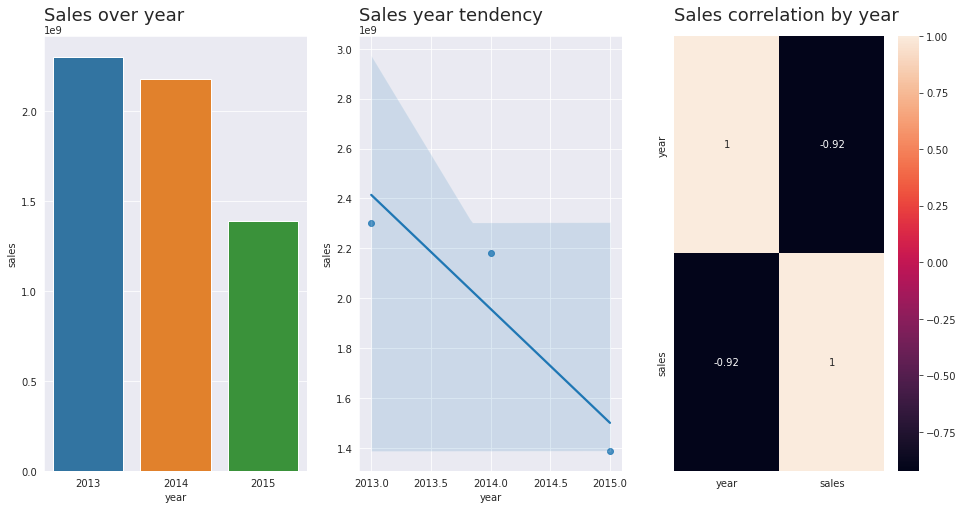

In [ ]:
aux1 = df2[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)
plt.title('Sales over year', loc='left', fontsize=18, pad=15.5)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)
graph_info('Sales year tendency')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)
graph_info('Sales correlation by year')

Year 2015 is not complet in this dataset

### H9 - In the second half, sales should increase

*False*

Sales decrease in the second half

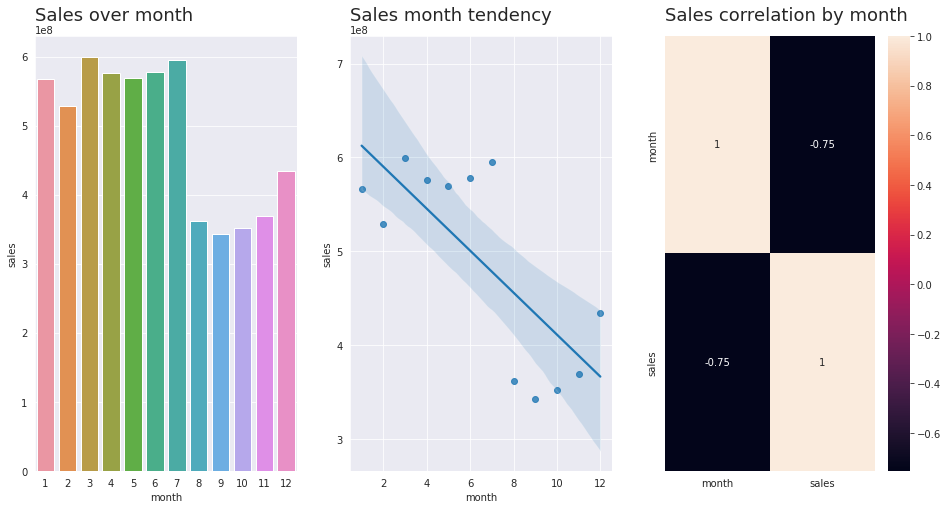

In [ ]:
aux1 = df2[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)
plt.title('Sales over month', loc='left', fontsize=18, pad=15.5)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
graph_info('Sales month tendency')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)
graph_info('Sales correlation by month')

### H10 - On weekend sales are lower

*True*

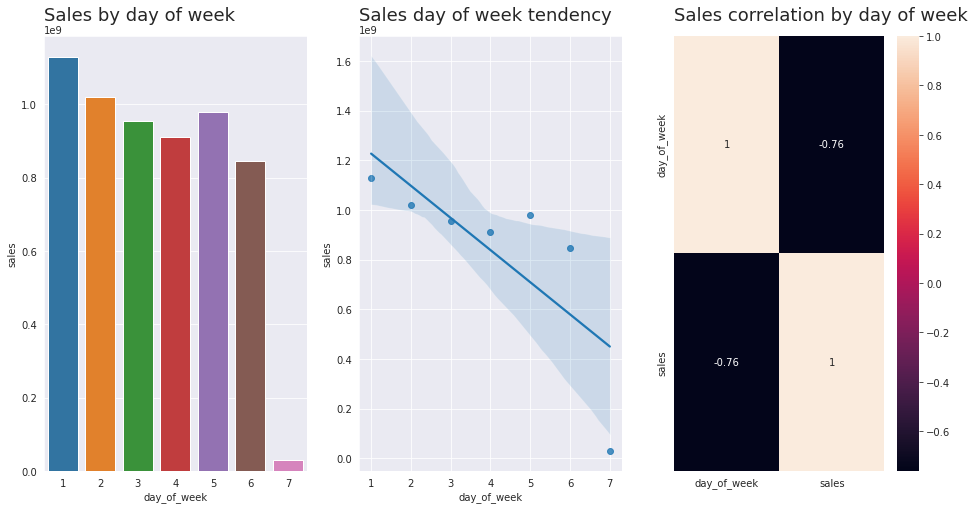

In [ ]:
aux1 = df2[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.title('Sales by day of week', loc='left', fontsize=18, pad=15.5)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
graph_info('Sales day of week tendency')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)
graph_info('Sales correlation by day of week')

### H11 - During school holidays sales are lower

True

August is an exception

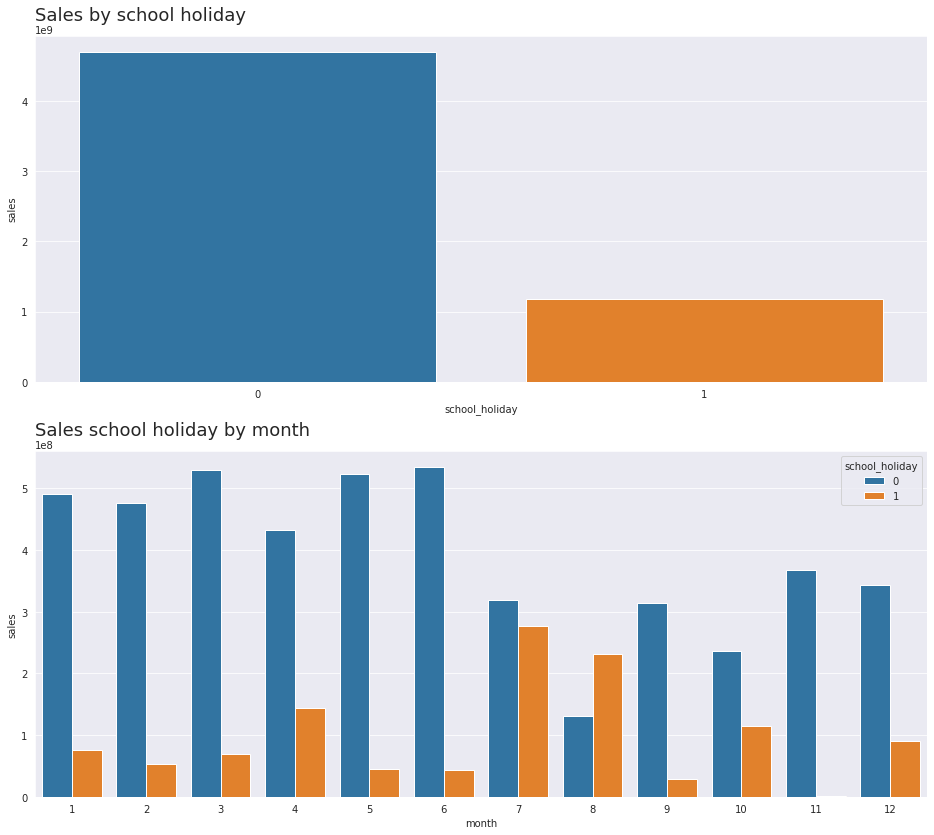

In [ ]:
aux1 = df2[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(16, 14))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title('Sales by school holiday', loc='left', fontsize=18, pad=15.5)

aux2 = df2[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
graph_info('Sales school holiday by month')

In August sales are highest on school holidays

### H12 - After the 10th of each month sales should be higher

False

Ather the 10th the tendency is lower

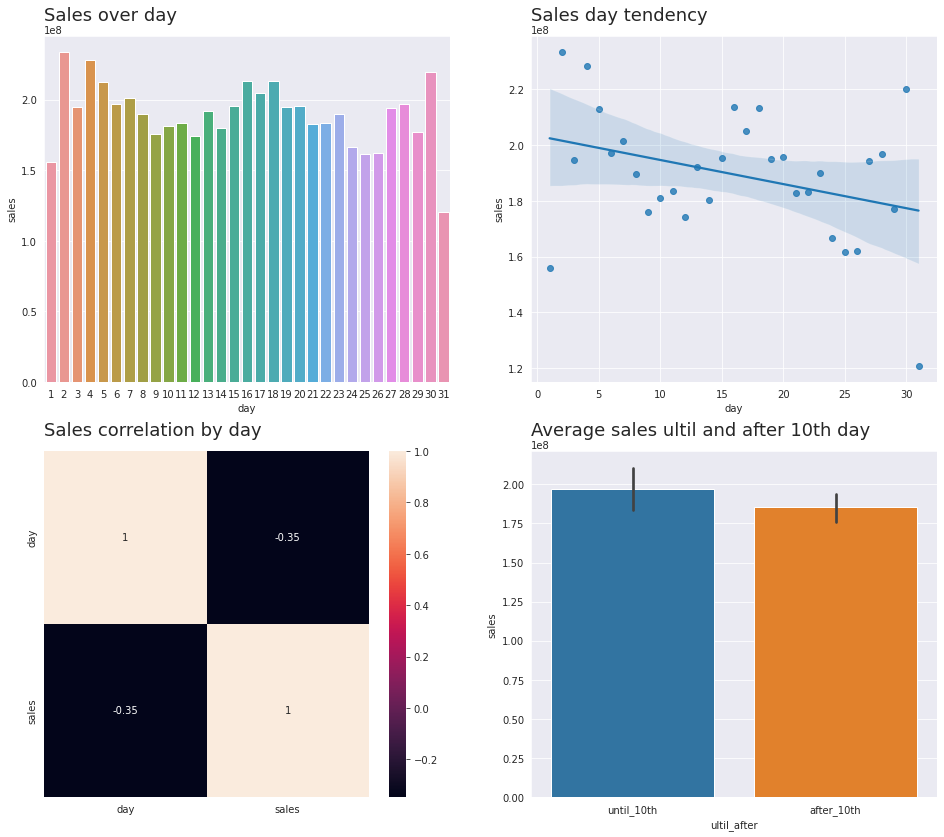

In [ ]:
aux1 = df2[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(16, 14))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Sales over day', loc='left', fontsize=18, pad=15.5)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)
graph_info('Sales day tendency')

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True)
graph_info('Sales correlation by day')

plt.subplot(2, 2, 4)
aux1['ultil_after'] = aux1['day'].apply(lambda x: 'until_10th' if x <= 10 else 'after_10th')
aux2 = aux1[['ultil_after', 'sales']].groupby('ultil_after').mean().reset_index()
sns.barplot(x='ultil_after', y='sales', data=aux1)
graph_info('Average sales ultil and after 10th day')

### Hypothesis summary

In [ ]:
tab = [
    ['Hypothesis', 'Description', 'Conclusion', 'Relevance'],
    ['H1', 'Stores with more assortment should sell more', 'False', 'Low'],
    ['H2', 'Stores with competition nearby sell less', 'False', 'Medium'],
    ['H3', 'Stores with longer-term competitors should sell more', 'False', 'Medium'],
    ['H4', 'Stores with promotions active for longer should sell more', 'False', 'Low'],
    ['H5', 'Stores with more promotion days should sell more', '-', '-'],
    ['H6', 'Stores with consecutive promotion should sell more', 'False', 'Low'],
    ['H7', 'At Christmas sales are higher', 'False', 'Low'],
    ['H8', 'Sales are higher over the years', 'False', 'High'],
    ['H9', 'In the second half, sales should increase', 'False', 'Medium'],
    ['H10', 'On weekend sales are lower', 'True', 'Low'],
    ['H11', 'During school holidays sales are lower', 'True', 'Low'],
    ['H12', 'After the 10th of each month sales should be higher', 'False', 'Low']
]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Description                                                Conclusion    Relevance
------------  ---------------------------------------------------------  ------------  -----------
H1            Stores with more assortment should sell more               False         Low
H2            Stores with competition nearby sell less                   False         Medium
H3            Stores with longer-term competitors should sell more       False         Medium
H4            Stores with promotions active for longer should sell more  False         Low
H5            Stores with more promotion days should sell more           -             -
H6            Stores with consecutive promotion should sell more         False         Low
H7            At Christmas sales are higher                              False         Low
H8            Sales are higher over the years                            False         High
H9            In the second half, sales should increase                

## Multivariate Analysis

### Numerical Variable

<AxesSubplot:>

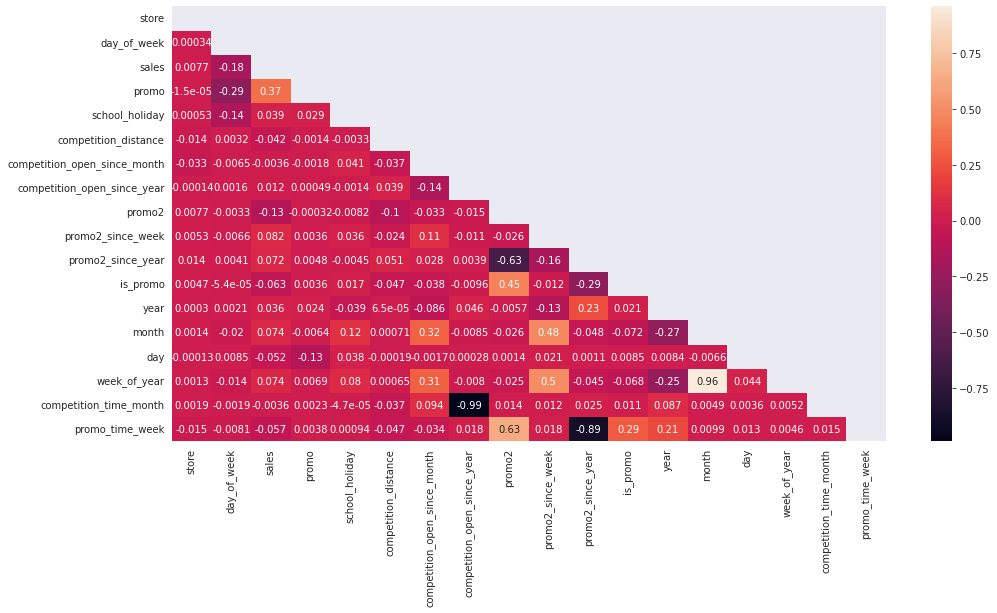

In [ ]:
mask = np.zeros_like(df2.select_dtypes(['int64', 'float64']).corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df2.select_dtypes(['int64', 'float64']).corr(), annot=True, mask=mask)

### Categorical Variable

In [ ]:
categoricals = df2.select_dtypes(include='object').iloc[:, 1:4]
categoricals.head()

state_holiday store_type assortment
0   regular_day          c      basic
1   regular_day          c      basic
2   regular_day          c      basic
3   regular_day          c      basic
4   regular_day          c      basic

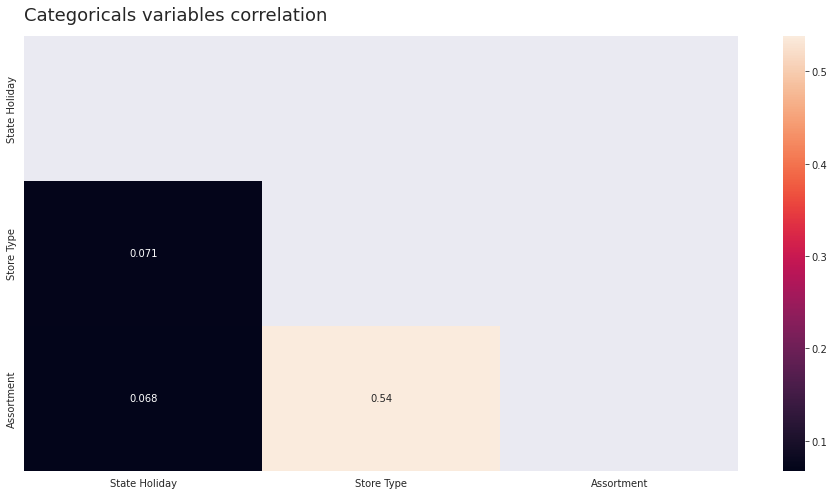

In [ ]:
categoricals_1 = cramer_v(categoricals['state_holiday'], categoricals['state_holiday'])
categoricals_2 = cramer_v(categoricals['state_holiday'], categoricals['store_type'])
categoricals_3 = cramer_v(categoricals['state_holiday'], categoricals['assortment'])

categoricals_4 = cramer_v(categoricals['store_type'], categoricals['state_holiday'])
categoricals_5 = cramer_v(categoricals['store_type'], categoricals['store_type'])
categoricals_6 = cramer_v(categoricals['store_type'], categoricals['assortment'])

categoricals_7 = cramer_v(categoricals['assortment'], categoricals['state_holiday'])
categoricals_8 = cramer_v(categoricals['assortment'], categoricals['store_type'])
categoricals_9 = cramer_v(categoricals['assortment'], categoricals['assortment'])

correlations = pd.DataFrame({
    'State Holiday': [categoricals_1, categoricals_2, categoricals_3],
    'Store Type': [categoricals_4, categoricals_5, categoricals_6],
    'Assortment': [categoricals_7, categoricals_8, categoricals_9]
})
correlations = correlations.set_index(correlations.columns)

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, annot=True, mask=mask)
graph_info('Categoricals variables correlation')

## Process File

In [ ]:
df2.to_csv('../data/processing/data_exploratory.csv', index=False)

# Data Modeling

In [5]:
df3 = pd.read_csv('../data/processing/data_exploratory.csv')

## Normalization

Don't have normal distribution to apply normalization properly.

## Rescaling

In [6]:
mms = MinMaxScaler()
rs = RobustScaler()

# Robust Scaler
# competition_distance
df3['competition_distance'] = rs.fit_transform(df3[['competition_distance']].values)

# competition_time_month
df3['competition_time_month'] = rs.fit_transform(df3[['competition_time_month']].values)

# Min Max Scaler
# promo_time_week
df3['promo_time_week'] = mms.fit_transform(df3[['promo_time_week']].values)

# year
df3['year'] = mms.fit_transform(df3[['year']].values)

# Cyclic
# competition_open_since_month

## Transformation

### Encoding

In [7]:
# State Holiday - OheHotEncoding
df3 = pd.get_dummies(df3, prefix=['state_holiday'], columns=['state_holiday'])

# Store Type - Label Encoding
le = LabelEncoder()
df3['store_type'] = le.fit_transform(df3['store_type'])

# Assortment - Ordina encoding
store_type = {'basic': 1, 'extra': 2, 'extended': 3}
df3['assortment'] = df3['assortment'].map(store_type)

### Response Variable Transformation

In [8]:
# response variable normalization
df3['sales'] = np.log1p(df3['sales'])

### Nature Transformation 

In [9]:
# day_of_week
df3['day_of_week_sin'] = df3['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df3['day_of_week_cos'] = df3['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
df3['month_sin'] = df3['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df3['month_cos'] = df3['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

#day
df3['day_sin'] = df3['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df3['day_cos'] = df3['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week_of_year
df3['week_of_year_sin'] = df3['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df3['week_of_year_cos'] = df3['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

### Transformation File

In [10]:
df3.to_csv('../data/processing/transformation.csv', index=False)

## Feature Selection 

In [11]:
df4 = pd.read_csv('../data/processing/transformation.csv')

### Split Dataframe - Train and Test

In [12]:
drop_cols = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df4.drop(drop_cols, axis=1, inplace=True)

In [13]:
# Training dataset
X_train = df4[df4['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df4[df4['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training min date: {X_train["date"].min()}')
print(f'Training max date: {X_train["date"].max()}')

print(f'\nTest min date: {X_test["date"].min()}')
print(f'Test max date: {X_test["date"].max()}')

Training min date: 2013-01-01
Training max date: 2015-06-18

Test min date: 2015-06-19
Test max date: 2015-07-31


### Boruta as Feature Selector 

In [14]:
# Training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values

# Define Random Forest Regressor
#rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [15]:
#cols_selected = boruta.support_.tolist()

#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### Selected Features Adjusted

In [16]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos'
]

# Columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## Process File

In [17]:
# Test file
X_test.to_csv('../data/processing/X_test.csv', index=False)

# Train and test files cols selected boruta
X_train[cols_selected_boruta].to_csv('../data/processing/feature_selection_x_train.csv', index=False)
X_test[cols_selected_boruta].to_csv('../data/processing/feature_selection_x_test.csv', index=False)

y_train.to_csv('../data/processing/y_train.csv', index=False)
y_test.to_csv('../data/processing/y_test.csv', index=False)

# Include sales and date
X_train[cols_selected_boruta_full].to_csv('../data/processing/feature_selection_x_train_full.csv', index=False)

# Columns selected boruta full
pd.Series(cols_selected_boruta_full).to_csv('../data/processing/cols_selected_boruta_full.csv', index=False)
 
# Bitbucket storage (large files)
X_train[cols_selected_boruta].to_csv('/home/marcos/Documents/bitbucket/data-science-producao/data/feature_selection_x_train.csv', index=False)
X_test[cols_selected_boruta].to_csv('/home/marcos/Documents/bitbucket/data-science-producao/data/feature_selection_x_test.csv', index=False)

y_train.to_csv('/home/marcos/Documents/bitbucket/data-science-producao/data/y_train.csv', index=False)
y_test.to_csv('/home/marcos/Documents/bitbucket/data-science-producao/data/y_test.csv', index=False)

# Include sales and date
X_train[cols_selected_boruta_full].to_csv('/home/marcos/Documents/bitbucket/data-science-producao/data/feature_selection_x_train_full.csv', index=False)

# Machine Learning

In [24]:
# Train and test files
x_train = pd.read_csv('../data/processing/feature_selection_x_train.csv')
x_test = pd.read_csv('../data/processing/feature_selection_x_test.csv')

y_train = pd.read_csv('../data/processing/y_train.csv')
y_train = y_train.values.ravel()
y_test = pd.read_csv('../data/processing/y_test.csv') 
y_test = y_test.values.ravel()

# Time Series Data Preparation
x_training = pd.read_csv('../data/processing/feature_selection_x_train_full.csv')
x_training['date'] = pd.to_datetime(x_training['date'])


'''
# Large file - Bitbucket
x_train = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/feature_selection_x_train.csv')
x_test = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/feature_selection_x_test.csv')

y_train = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/y_train.csv')
y_train = y_train.values.ravel()
y_test = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/y_test.csv')
y_test = y_test.values.ravel()

# Time Series Data Preparation
x_training = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/feature_selection_x_train_full.csv')
x_training['date'] = pd.to_datetime(x_training['date'])
'''

"\n# Large file - Bitbucket\nx_train = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/feature_selection_x_train.csv')\nx_test = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/feature_selection_x_test.csv')\n\ny_train = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/y_train.csv')\ny_train = y_train.values.ravel()\ny_test = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/y_test.csv')\ny_test = y_test.values.ravel()\n\n# Time Series Data Preparation\nx_training = pd.read_csv('https://bitbucket.org/MarcosRMG/data-science-producao/raw/2f06a1c212147309a710b726ba10fdfc20533e11/data/feature_selection_x_train_full.csv')\nx_training['date'] = pd.to_datetime(x_training['date'])\n"

## Average Model 

In [ ]:
# Prediction
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

Model Name          MAE    MAPE         MRSE
0  Average Model  1354.800353  0.2064  1835.135542

## Linear Regression 

In [ ]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

Model Name          MAE      MAPE         MRSE
0  Linear Regression  1869.922218  0.295044  2667.521087

### Linear Regression - Cross validation

In [ ]:
lr_cv = cross_validation(x_training, lr, 'Linear Regression', 5)
lr_cv

Model             MAE CV      MAPE CV            MRSE CV
0  Linear Regression  2079.28 +- 303.04  0.3 +- 0.02  2961.07 +- 473.32

## Linear Regression Regularized

In [ ]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# predict
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

Model Name          MAE      MAPE         MRSE
0  Linear Regression Regularized  1891.194993  0.289872  2741.003248

### Linear Regression Regularized - Cross validation

In [ ]:
lrr_cv = cross_validation(x_training, lrr, 'Lasso', 5)
lrr_cv

Model             MAE CV       MAPE CV            MRSE CV
0  Lasso  2116.98 +- 342.05  0.29 +- 0.01  3059.41 +- 504.65

## Random Forest Regressor

In [ ]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

Model Name         MAE      MAPE         MRSE
0  Random Forest Regressor  743.435045  0.110389  1092.371159

### Random Forest Regressor - Cross Validation

In [ ]:
rf_cv = cross_validation(x_training, rf, 'Random Forest Regressor', 5, True)
rf_cv


K number: 5

K number: 4

K number: 3

K number: 2

K number: 1


Model           MAE CV       MAPE CV            MRSE CV
0  Random Forest Regressor  840.91 +- 223.3  0.12 +- 0.02  1259.56 +- 328.92

## XGBoost Regressor

In [ ]:
# Model
xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10, subsimple=0.7,
                      colsample_bytee=0.9).fit(x_train, y_train)
# Prediction
yhat_xgb = xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

Model Name         MAE      MAPE         MRSE
0  XGBoost Regressor  876.306011  0.129724  1273.145439

### XGBoost Regressor - Cross Validation

In [ ]:
xgb_cv = cross_validation(x_training, xgb, 'XGBoost Regressor', 5, True)
xgb_cv


K number: 5

K number: 4

K number: 3

K number: 2

K number: 1


Model             MAE CV       MAPE CV           MRSE CV
0  XGBoost Regressor  1059.12 +- 193.55  0.15 +- 0.02  1528.25 +- 272.4

## Compare Models Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('MRSE')

Model Name          MAE      MAPE         MRSE
0        Random Forest Regressor   743.435045  0.110389  1092.371159
0              XGBoost Regressor   876.306011  0.129724  1273.145439
0                  Average Model  1354.800353  0.206400  1835.135542
0              Linear Regression  1869.922218  0.295044  2667.521087
0  Linear Regression Regularized  1891.194993  0.289872  2741.003248

## Real Performance Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_cv, lrr_cv, rf_cv, xgb_cv])
modelling_result_cv.sort_values('MRSE CV')

Model             MAE CV       MAPE CV            MRSE CV
0  Random Forest Regressor    840.91 +- 223.3  0.12 +- 0.02  1259.56 +- 328.92
0        XGBoost Regressor  1059.12 +- 193.55  0.15 +- 0.02   1528.25 +- 272.4
0        Linear Regression  2079.28 +- 303.04   0.3 +- 0.02  2961.07 +- 473.32
0                    Lasso  2116.98 +- 342.05  0.29 +- 0.01  3059.41 +- 504.65

# Hyperparameter Fine Tuning

## Random Search

In [11]:
param = {
    'n_estimators': [15, 17, 25, 30, 35],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.9],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [12]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
  # chose values for parameter randomly
  hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
  print(hp)

  model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=hp['n_estimators'], 
                         eta=hp['eta'], max_depth=hp['max_depth'], 
                         subsimple=hp['subsample'], 
                         colsample_bytee=hp['min_child_weight'])
  
  result = cross_validation(x_training, model_xgb, 'XGBRegressor', 5)
  final_result = pd.concat([final_result, result])

final_result 

{'n_estimators': 35, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 15, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 25, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 25, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 25, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 15}


Model             MAE CV       MAPE CV            MRSE CV
0  XGBRegressor   2415.4 +- 357.66  0.29 +- 0.02   3426.4 +- 470.97
0  XGBRegressor   6158.5 +- 543.61  0.82 +- 0.01  6859.03 +- 648.82
0  XGBRegressor  3675.96 +- 390.19  0.45 +- 0.02  4500.97 +- 500.25
0  XGBRegressor  3743.24 +- 433.87  0.45 +- 0.02  4653.41 +- 535.75
0  XGBRegressor  3675.96 +- 390.19  0.45 +- 0.02  4500.97 +- 500.25

## Final Model

In [13]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [8]:
'''
xgb_model_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], 
                                   max_depth=param_tuned['max_depth'],
                                   subsimple=param_tuned['subsample'], 
                                   colsample_bytee=param_tuned['min_child_weight']).fit(x_train, y_train)
'''
xgb_model_tuned = pd.read_pickle('../data/model/xgb_result_tuned.pickle')
yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGB Regressor', np.expm1(y_test), 
                            np.expm1(yhat_xgb_tuned))
xgb_result_tuned

FileNotFoundError: [Errno 2] No such file or directory: '../data/model/xgb_result_tuned.pickle'

In [18]:
xgb_result_tuned

Model Name         MAE     MAPE        MRSE
0  XGB Regressor  681.652667  0.10123  971.368123

## Process File

In [ ]:
# xgb model tuned
#pickle.dump(xgb_model_tuned, open('../data/model/xgb_model_tuned.pickle', 'wb'))

# Prediction xgb tunned
#pickle.dump(yhat_xgb_tuned, open('../data/model/yhat_xgb_tuned.pickle', 'wb'))

# Error Interpretation

In [32]:
# Read process data
X_test = pd.read_csv('../data/processing/X_test.csv')
cols_selected_boruta_full = pd.read_csv('../data/processing/cols_selected_boruta_full.csv')
cols_selected_boruta_full.rename(columns={'0': 'variables'}, inplace=True)
cols_selected_boruta_full = cols_selected_boruta_full['variables'].to_list()
yhat_xgb_tuned = pd.read_pickle('../data/models/yhat_xgb_tuned.pickle')

df9 = X_test[cols_selected_boruta_full]
# Rescale
df9['sales'] = np.expm1(df9['sales'])

#yhat_xgb_tuned
df9['predictions'] = np.expm1(yhat_xgb_tuned)

# Date type
df9['date'] = pd.to_datetime(df9['date'])

/tmp/ipykernel_3038/3047525054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_3038/3047525054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)
/tmp/ipykernel_3038/3047525054.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Business Performance

In [34]:
# Sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# Mae e Mape
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'}) 
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'}) 

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [14]:
df92.sort_values('MAE', ascending=False).head()

store    predictions  worst_scenario  best_scenario          MAE  \
908    909  247951.640625   240441.888353  255461.392897  7509.752272   
875    876  210874.484375   206993.390052  214755.578698  3881.094323   
291    292  106527.835938   103190.096525  109865.575350  3337.739412   
594    595  415237.312500   412131.810019  418342.814981  3105.502481   
841    842  713526.750000   711155.185547  715898.314453  2371.564453   

         MAPE  
908  0.526084  
875  0.310266  
291  0.582259  
594  0.218828  
841  0.113178

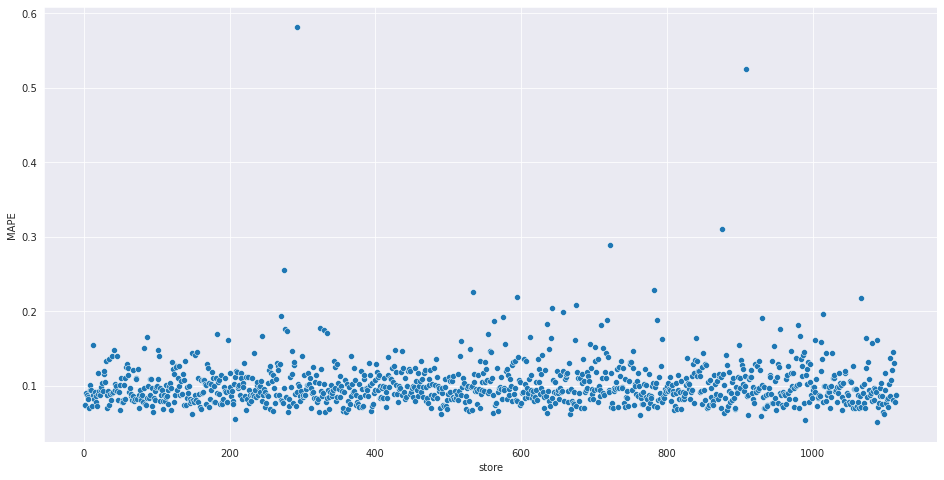

In [18]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## Total Performance

In [35]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].sum(axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

Scenario             Values
0     predictions  R$ 288,936,960.00
1  worst_scenario  R$ 288,173,160.63
2   best_scenario  R$ 289,700,763.82

## Machine Learning Performance

In [36]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_3038/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_3038/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/home/marcos/Documents/data_science_em_producao/env_ds_producao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marcos/Documents/data_science_em_producao/env_ds_producao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


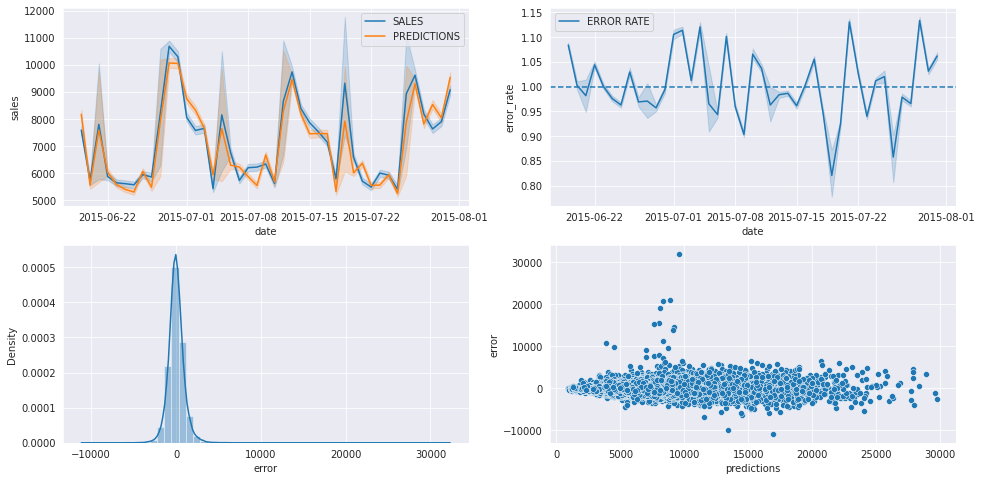

In [37]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9, label='ERROR RATE')
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])
plt.show()